In [ ]:
# for my own ting
%cd /home/dev/ws_neuroai

## RDMS BABBYYYYYY

In [ ]:
!pip install wandb --quiet
import wandb, re
wandb.login(
  key=""      # <<<<<<<<<<<<<<<<<< paste your api key here
)
api = wandb.Api()

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## RDM

In [ ]:
from utils.data_utils import download_mnist

_, valid_set, _ = download_mnist()

valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=configs['batch_size'], shuffle=False, drop_last=True)

In [ ]:
from collections import defaultdict

class Sampler():
    def __init__(self, dataset):
        self.dataset = defaultdict(list)
        for i, (tensor, label) in enumerate(dataset):
                self.dataset[label].append(tensor)

        self.batches = self.batch()

    def batch(self, batch_size=32):    
        all_batches = dict()
        for label, tensor_list in self.dataset.items():
            num_batches = len(tensor_list) // batch_size     
            batches = []

            for i in range(num_batches):
                my_batch = torch.stack(tensor_list[i* batch_size:(i + 1) * batch_size], dim=0)
                batches.append(my_batch)
            all_batches[label] = batches
        return all_batches  

    def tips(self):
        n = 0 
        print("classes\tcounts")
        for label, tensors in sampler.dataset.items():
            print(f"{label}\t{len(tensors)}")
            n+=len(tensors)
        print(f"n={n}")

    
sampler = Sampler(valid_set)
batches = sampler.batches

In [ ]:
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [180]:
class ModelWrapper():
    def __init__(self, device):
        self.device = device

    def retrieve_models(self):
        all_runs = dict()
        entity = "adorable-lantanas"
        project = "all-rules"
        project_path = f"{entity}/{project}"
        runs = api.runs(project_path)

        # get the runs
        for rule in [
            'hebb',
            'np',
            'wp',
            'backprop', 
        ]:
            search_pattern = f"tbishnoi-run-0-{rule}-6"
            for run in runs:
                if re.search(search_pattern, run.name):        
                    all_runs[rule] = run

        return self.load_models(all_runs)

    def load_models(self, all_runs):
        models = dict()
        for rule, run in all_runs.items():
            models[rule] = self.load_model(run)        
        return models

    def load_model(self, run):
        device = self.device

        configs = run.config
        run_id = run.id 

        if configs['rule_select'] == 'backprop':

            from rules.classes.MLP import MultiLayerPerceptron 
            class Model(MultiLayerPerceptron):
                def forward(self, X, y=None):
                    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
                    y_pred = self.softmax(self.lin2(h))
                    return y_pred.detach(), h.detach()

            model = Model(
                num_inputs=configs['num_inputs'],
                num_hidden=configs['num_hidden'],
                num_outputs=configs['num_outputs'],
                bias=configs['bias'],
                activation_type=configs['activation_type'],
            ).to(device)    


        elif configs['rule_select'] == 'hebb':


            from rules.Hebbian import HebbianNetwork, HebbianFunction
            class Model(HebbianNetwork):
                def forward(self, X, y=None):
                    h = HebbianFunction.apply(
                        X.reshape(-1, self.num_inputs),
                        self.lin1.weight,
                        self.lin1.bias,
                        self.activation,
                    )    

                    if y is None or not self.clamp_output:
                        targets = None
                    else:
                        targets = torch.nn.functional.one_hot(
                            y, num_classes=self.num_outputs
                        ).float()

                    y_pred = HebbianFunction.apply(
                        h,
                        self.lin2.weight,
                        self.lin2.bias,
                        self.softmax,
                        targets
                    )
                    return y_pred.detach(), h.detach()

            model = Model(
                num_inputs=configs['num_inputs'],
                num_hidden=configs['num_hidden'],
                num_outputs=configs['num_outputs'],
                clamp_output=configs['clamp_output'],
                bias=configs['bias'],
            ).to(device)

        elif configs['rule_select'] == 'wp': # change to accepting kwargs

            from rules.WP import WeightPerturbMLP
            class Model(WeightPerturbMLP):
                def forward(self, X, y=None):
                    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
                    y_pred = self.softmax(self.lin2(h)) #probability distribution
                    return y_pred.detach(), h.detach()

            model = Model(
                num_inputs=configs['num_inputs'],
                num_hidden=configs['num_hidden'],
                num_outputs=configs['num_outputs'],
                bias=configs['bias'],
                activation_type=configs['activation_type'],
                sigma=configs['sigma'],
            ).to(device)

        elif configs['rule_select'] == 'np':

            from rules.NP import NodePerturbMLP
            class Model(NodePerturbMLP):
                def forward(self, X, y=None):
                    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
                    y_pred = self.softmax(self.lin2(h)) #probability distribution
                    return y_pred.detach(), h.detach()

            model = Model(
                num_inputs=configs['num_inputs'],
                num_hidden=configs['num_hidden'],
                num_outputs=configs['num_outputs'],
                bias=configs['bias'],
                activation_type=configs['activation_type'],
                sigma=configs['sigma'],
            ).to(device)

        else:
            raise NotImplementedError("Selected Rule does not exist!")

        model_filepath = configs['model_filepath']
        file = run.file(model_filepath)
        _ = file.download(replace=True, root=".")
        
        model.load_state_dict(
            torch.load(
                model_filepath,
                map_location=torch.device(device.type),
            )
        )
        return model.to(device)

model_wrapper = ModelWrapper(device)

models = model_wrapper.retrieve_models()
models

{'hebb': Model(
   (lin1): Linear(in_features=784, out_features=100, bias=True)
   (lin2): Linear(in_features=100, out_features=10, bias=True)
   (activation): Sigmoid()
   (softmax): Softmax(dim=1)
 ),
 'np': Model(
   (lin1): Linear(in_features=784, out_features=100, bias=True)
   (lin2): Linear(in_features=100, out_features=10, bias=True)
   (activation): ReLU()
   (softmax): Softmax(dim=1)
 ),
 'wp': Model(
   (lin1): Linear(in_features=784, out_features=100, bias=True)
   (lin2): Linear(in_features=100, out_features=10, bias=True)
   (activation): ReLU()
   (softmax): Softmax(dim=1)
 ),
 'backprop': Model(
   (lin1): Linear(in_features=784, out_features=100, bias=True)
   (lin2): Linear(in_features=100, out_features=10, bias=True)
   (activation): ReLU()
   (softmax): Softmax(dim=1)
 )}

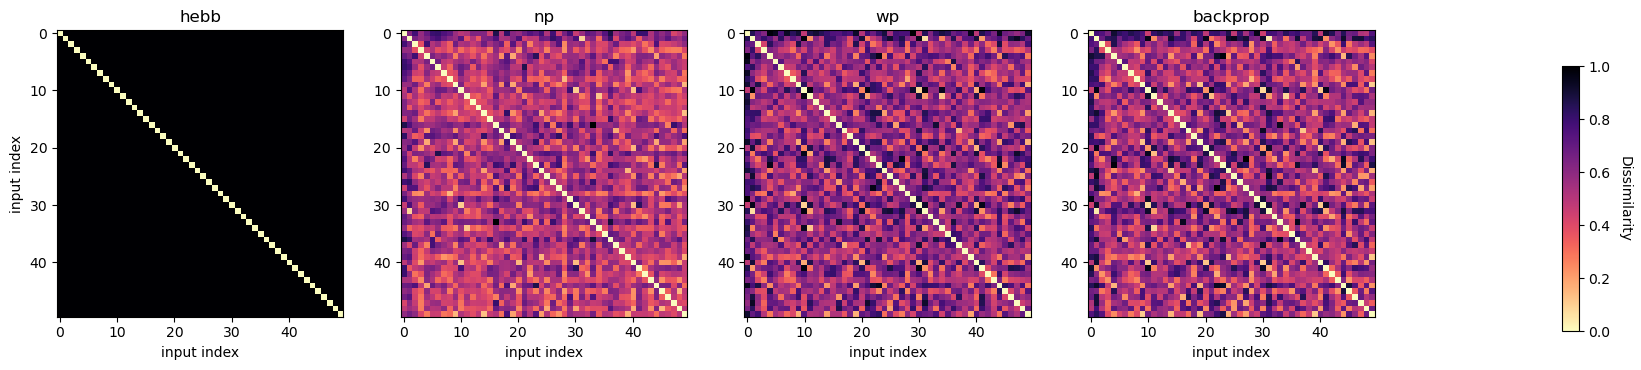

In [182]:
def plot_maps(
    model_features,
    #model_name
):
    fig = plt.figure(figsize=(17, 5))
    # fig.suptitle(f"RDMs across layers for {model_name}")
    # and we add one plot per reference point
    gs = fig.add_gridspec(1, len(model_features))
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    for l in range(len(model_features)):

        layer = list(model_features.keys())[l]
        map_ = np.squeeze(model_features[layer])

        if len(map_.shape) < 2:
            map_ = map_.reshape( (int(np.sqrt(map_.shape[0])), int(np.sqrt(map_.shape[0]))) )

        map_ = map_ / np.max(map_)

        ax = plt.subplot(gs[0,l])
        ax_ = ax.imshow(map_, cmap='magma_r')
        ax.set_title(f'{layer}')
        ax.set_xlabel("input index")
        if l==0:
            ax.set_ylabel("input index")

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
    cbar = fig.colorbar(ax_, cax=cbar_ax)
    cbar.set_label('Dissimilarity', rotation=270, labelpad=15)

    plt.show()


def calc_rdms(models, batches, batch_size):
    ds_dict = dict()

    # create batch
    X = torch.cat(
        [batches[input_class][0][:batch_size].to(device)\
            for input_class in range(0,10)], dim=1)

    
    for key, model in models.items():
        # get prediction
        y_pred, h = model.forward(X)
        y_pred = torch.argmax(y_pred, dim=1)

        feats = h
        if len(feats.shape) > 2:
            feats = feats.flatten(1)
        ds = Dataset(
            feats.cpu().detach().numpy(), 
            descriptors=dict(
                layer='hidden layer', rule=key,
            )
        )
        ds_dict[key] = ds

    return ds_dict #ds_list, feature_list

method='correlation'
ds_dict = calc_rdms(models, batches, 5)
rdms = calc_rdm(list(ds_dict.values()), method=method)
rdms_dict = {key: rdms.get_matrices()[i] for i, (key, rdm) in enumerate(zip(list(ds_dict.keys()), rdms))}
plot_maps(rdms_dict)

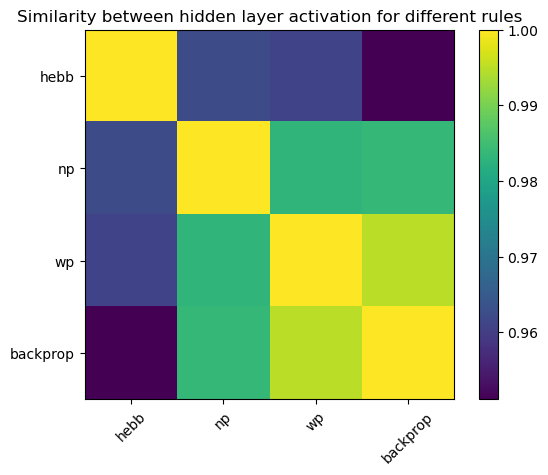

In [187]:

new_rdms = rsatoolbox.rdm.concat(rdms)
rdms_comp = rsatoolbox.rdm.compare(new_rdms, new_rdms, method='cosine')

labels = ['hebb', 'np', 'wp', 'backprop',]
plt.imshow(rdms_comp, cmap='viridis', interpolation='nearest')

plt.title('Similarity between hidden layer activation for different rules')
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

# Show the plot
plt.colorbar()  # Optional: Add a colorbar
plt.show()
